In [2]:
import json
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# New York

In [21]:
contents = urllib.request.urlopen(
    "https://data.covidactnow.org/latest/us/states/NY.OBSERVED_INTERVENTION.timeseries.json"
).read().decode('utf8')
nydata = json.loads(contents)

https://www.microcovid.org/paper/7-basic-method#step-two-underreporting-factor

We use these multipliers:

    If the percentage of positive tests is 5% or lower, we suggest a 6x underreporting factor.[4]

    If the percentage of positive tests is between 5% and 15%, we suggest a 8x factor.

    If the percentage of positive tests is greater than 15%, we suggest at least a 10x factor. This indicates dangerously little testing in your area compared to the number of infected people.


In [59]:
def get_multiplier(el):
    # Assume a 10x multiplier if no test positivity ratio
    # is available. Mainly because missing data is early
    # during rapid growth phase for NY, Spain.
    if pd.isna(el):
        return 10 #6
    elif el <= 0.05:
        return 6
    elif el <= 0.15:
        return 8
    elif el > 0.15:
        return 10

In [60]:
metrics = pd.DataFrame(nydata['metricsTimeseries'])
metrics = metrics[['date', 'testPositivityRatio']]
metrics['date'] = pd.to_datetime(metrics['date'])
metrics['multiplier'] = metrics['testPositivityRatio'].apply(get_multiplier)

cases = pd.DataFrame(nydata['actualsTimeseries'])
cases =  cases[['date', 'cumulativeConfirmedCases']]
cases['date'] = pd.to_datetime(cases['date'])
cases.sort_values(by='date', ascending=True)
cases.set_index('date', inplace=True)
cases['new_cases'] = cases['cumulativeConfirmedCases'].diff()
cases = cases.dropna()
cases.reset_index(drop=False, inplace=True)

est_cases = metrics.merge(cases, on='date')
est_cases['estimated_cases'] = est_cases['new_cases'] * est_cases['multiplier']
est_cases

,date,testPositivityRatio,multiplier,cumulativeConfirmedCases,new_cases,estimated_cases
0,2020-03-02,NaN,10,1.0,0.0,0.0
1,2020-03-03,NaN,10,2.0,1.0,10.0
2,2020-03-04,NaN,10,11.0,9.0,90.0
3,2020-03-05,0.363636,10,22.0,11.0,110.0
4,2020-03-06,0.380282,10,44.0,22.0,220.0
...,...,...,...,...,...,...
192,2020-09-10,0.008971,6,446637.0,756.0,4536.0
193,2020-09-11,0.009063,6,447498.0,861.0,5166.0
194,2020-09-12,0.009099,6,448347.0,849.0,5094.0
195,2020-09-13,0.009317,6,449072.0,725.0,4350.0


In [61]:
est_cases.describe()

,testPositivityRatio,multiplier,cumulativeConfirmedCases,new_cases,estimated_cases
count,194.000000,197.000000,197.000000,197.000000,197.000000
mean,0.109436,7.370558,312442.619289,2282.522843,20623.624365
std,0.147683,1.752475,148239.338938,2906.914878,29992.285098
min,0.007526,6.000000,1.000000,0.000000,0.000000
25%,0.010094,6.000000,251608.000000,626.000000,3768.000000
50%,0.014273,6.000000,383591.000000,779.000000,4674.000000
75%,0.173796,10.000000,417056.000000,2715.000000,21720.000000
max,0.507358,10.000000,449658.000000,12274.000000,122740.000000


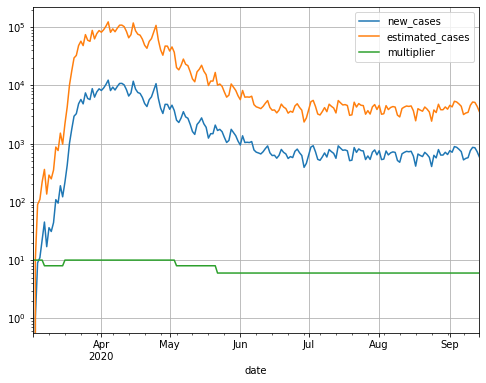

In [73]:
est_cases.plot(x='date', y=['new_cases', 'estimated_cases', 'multiplier'],
    kind='line', grid=True, logy=True, figsize=(8,6))

In [63]:
# Just assume April 23 was the end date, even though that's when it was reported
total_observed_cases = est_cases[est_cases['date'] < '2020-04-23']['new_cases'].sum()
total_estimated_cases = est_cases[est_cases['date'] < '2020-04-23']['estimated_cases'].sum()
pop = nydata['population']
print('Observed infection rate:', total_observed_cases/pop)
print('Estimated infection rate:', total_estimated_cases/pop)

Observed infection rate: 0.013446895403880041
Estimated infection rate: 0.13439822148757238


New York state did a preliminary [seroprevalence study](https://twitter.com/NYGovCuomo/status/1253352837255438338) completed on April 23rd that estimated a New York City infection rate of `21.2%` and a statewide rate of `13.9%`. The multiplier approach does really well, estimating `13.4%` seroprevalence at that date. This was early in pandemic, how well does this approach work now that some locations have built up more testing capacity?

# Spain

In [44]:
spainsource = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [46]:
spaindata = spainsource.copy()
spaindata = spaindata[spaindata.iso_code == 'ESP']
spaindata = spaindata[['date', 'new_cases', 'positive_rate']]
spaindata['date'] = pd.to_datetime(spaindata['date'])
# Get rid of zero days, for plot
spaindata = spaindata[spaindata['new_cases'] != 0]
spaindata['multiplier'] = spaindata['positive_rate'].apply(get_multiplier)
spaindata['estimated_cases'] = spaindata['new_cases']*spaindata['multiplier']
spaindata

,date,new_cases,positive_rate,multiplier,estimated_cases
36918,2020-02-01,1.0,NaN,10,10.0
36927,2020-02-10,1.0,NaN,10,10.0
36942,2020-02-25,1.0,NaN,10,10.0
36943,2020-02-26,6.0,NaN,10,60.0
36944,2020-02-27,8.0,NaN,10,80.0
...,...,...,...,...,...
37139,2020-09-09,8866.0,0.101,8,70928.0
37140,2020-09-10,10764.0,0.104,8,86112.0
37141,2020-09-11,12183.0,0.107,8,97464.0
37144,2020-09-14,27404.0,NaN,10,274040.0


In [47]:
spaindata.describe()

,new_cases,positive_rate,multiplier,estimated_cases
count,184.000000,125.000000,184.000000,184.000000
mean,3278.081522,0.046296,7.760870,28052.423913
std,4477.298175,0.050818,1.782548,39448.516695
min,-713.000000,0.008000,6.000000,-7130.000000
25%,395.500000,0.013000,6.000000,2394.000000
50%,1359.500000,0.025000,8.000000,8361.000000
75%,4701.000000,0.072000,10.000000,45402.500000
max,27404.000000,0.278000,10.000000,274040.000000


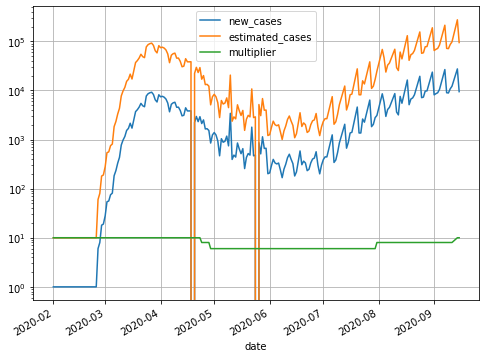

In [74]:
# A bit of a mess because not smoothed, but multiplier appears to be working.
spaindata.plot(x='date', y=['new_cases', 'estimated_cases', 'multiplier'],
    kind='line', grid=True, logy=True, figsize=(8,6))

In [49]:
# https://en.wikipedia.org/wiki/Demographics_of_Spain
spainpop = 47007367
spaincases = spaindata[spaindata['date'] <= '2020-05-13']['new_cases'].sum()
spainestimates = spaindata[spaindata['date'] <= '2020-05-13']['estimated_cases'].sum()
print('Observed infection rate:', spaincases/spainpop)
print('Estimated infection rate:', spainestimates/spainpop)

Observed infection rate: 0.00486500339404247
Estimated infection rate: 0.04692102835710837


Based on the total reported count, `0.48%` of the nation has been infected as of 5/13/2020, while [seroprevalence](https://www.reuters.com/article/us-health-coronavirus-spain-study/spanish-antibody-study-points-to-5-of-population-affected-by-coronavirus-idUSKBN22P2RP) [says](https://www.vox.com/2020/5/16/21259492/covid-antibodies-spain-serology-study-coronavirus-immunity) `5%`. So there's a 10x undercount of official cases. The model predicts around `4.7%` of Spain has been infected (`3.05%` if you fill in missing early values with 6x multiplier instead of 10x). Overall this seems to perform really well, but I still wonder if it will undercount in places with really good testing capacity? Or will places with good testing capacity not tend to have large outbreaks?  